### Install the necessary packages

In [ ]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 42.1MB/s 
     |████████████████████████████████| 2.9MB 39.5MB/s 
     |████████████████████████████████| 3.0MB 41.6MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


### Download the code zip file

In [ ]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/face-mask-detection/face-mask-detector.zip
!unzip -qq face-mask-detector.zip
%cd face-mask-detector

--2021-06-21 02:58:50--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/face-mask-detection/face-mask-detector.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.169.216
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.169.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74053692 (71M) [application/zip]
Saving to: ‘face-mask-detector.zip’

face-mask-detector. 100%[===================>]  70.62M  51.4MB/s    in 1.4s    

2021-06-21 02:58:52 (51.4 MB/s) - ‘face-mask-detector.zip’ saved [74053692/74053692]

/content/face-mask-detector


### Import Packages

In [ ]:
# import packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imutils
import time
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [ ]:
def plt_imshow(title, image):
    # 將圖像 BGR 轉換為 RGB 色彩空間並顯示出來
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()


### Implementing our COVID-19 face mask detector training script with Keras and TensorFlow

In [ ]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# 抓取框架的尺寸，然後從中構建一個 blob
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# 通過network傳遞blob並取得人臉偵測
	faceNet.setInput(blob)
	detections = faceNet.forward()

  # 初始化人臉列表、對應的位置以及face mask network的預測列表
	faces = []
	locs = []
	preds = []

	# 使用for迴圈偵測 
	for i in range(0, detections.shape[2]):
		# 提取與偵測相關的可信度（即機率）
		confidence = detections[0, 0, i, 2]

		# 通過確保可信度大於最小可信度來過濾掉弱檢測
		if confidence > args["confidence"]:
			# 計算物件邊界框的 (x, y) 坐標
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# 確保邊界框在框架的尺寸範圍內
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# 抓取人臉 ROI值，將其從 BGR 轉換為 RGB，將其調整為 224x224大小，並對其進行前處理
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# 將人臉和邊界框加到各自的列表中
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# 當在偵測到至少一張臉時才進行預測
	if len(faces) > 0:
    # 為了更快的進行，將同時對所有人臉進行批次的預測，而不是在for迴圈中逐一預測
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

  # 返回人臉位置及其對應位置的雙重物件
	return (locs, preds)

In [ ]:
args = {
    "dataset": "dataset",
    "plot": "plot.png",
    "model": "mask_detector.model",

}

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
# 獲取資料集的圖像，然後初始化
# 抓住所有的圖像路徑
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

print(imagePaths)

# 使用loop讀取全部的圖像路徑
for imagePath in imagePaths:
	# 從資料夾提取標籤類別
	label = imagePath.split(os.path.sep)[-2]

	# 載入輸入的影像(224x224)並且進行預處理
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# 將預處理的影像和標籤類別加到資料和標籤列表中
	data.append(image)
	labels.append(label)

# 確保訓練資料是NumPy格式
data = np.array(data, dtype="float32")
labels = np.array(labels)

# 對標籤執行 one-hot 編碼
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

print(labels)

['dataset/without_mask/augmented_image_162.jpg', 'dataset/without_mask/50.jpg', 'dataset/without_mask/87.jpg', 'dataset/without_mask/augmented_image_149.jpg', 'dataset/without_mask/45.jpg', 'dataset/without_mask/augmented_image_231.jpg', 'dataset/without_mask/275.jpg', 'dataset/without_mask/231.jpg', 'dataset/without_mask/augmented_image_113.jpg', 'dataset/without_mask/339.jpg', 'dataset/without_mask/augmented_image_137.jpg', 'dataset/without_mask/augmented_image_44.jpg', 'dataset/without_mask/405.jpg', 'dataset/without_mask/414.jpg', 'dataset/without_mask/augmented_image_226.jpg', 'dataset/without_mask/348.jpg', 'dataset/without_mask/288.jpg', 'dataset/without_mask/445.jpg', 'dataset/without_mask/360.jpg', 'dataset/without_mask/augmented_image_176.jpg', 'dataset/without_mask/augmented_image_78.jpg', 'dataset/without_mask/79.jpg', 'dataset/without_mask/augmented_image_61.jpg', 'dataset/without_mask/augmented_image_111.jpg', 'dataset/without_mask/augmented_image_202.jpg', 'dataset/witho

In [ ]:
# 有80%的訓練集，20%的測試集
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# 數據增強
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# 載入MobileNetV2 network，並進行修改
# 向MobileNet載入預訓練的ImageNet權重
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# 修改原本的fully-connected層
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# 將修改過的fully-connected放在最頂端，最後使用此進行訓練
model = Model(inputs=baseModel.input, outputs=headModel)

# 凍結network的基礎層，當在進行第一次訓練的時候不會被更新，可以加快訓練節省時間
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# 編譯模型
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 12s 342ms/step - loss: 0.5285 - accuracy: 0.7622 - val_loss: 0.1639 - val_accuracy: 0.9710
Epoch 2/20
34/34 [==============================] - 10s 291ms/step - loss: 0.1519 - accuracy: 0.9532 - val_loss: 0.0888 - val_accuracy: 0.9746
Epoch 3/20
34/34 [==============================] - 10s 294ms/step - loss: 0.0875 - accuracy: 0.9747 - val_loss: 0.0590 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 10s 289ms/step - loss: 0.0706 - accuracy: 0.9775 - val_loss: 0.0440 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 10s 293ms/step - loss: 0.0517 - accuracy: 0.9860 - val_loss: 0.0365 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 10s 290ms/step - loss: 0.0415 - accuracy: 0.9888 - val_loss: 0.0335 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 10s 291ms/step - loss: 0.0412 - accuracy

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276

[INFO] saving mask detector model...


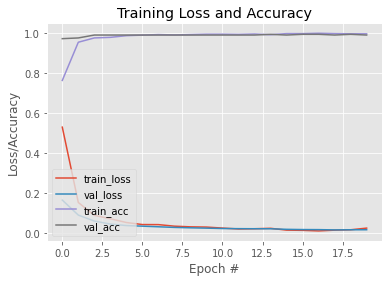

In [ ]:
# 對測試集進行預測
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# 對測試集的每個影像進行，並且找到概率最高的類別標籤索引
predIdxs = np.argmax(predIdxs, axis=1)

# 輸出值進行檢查
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# 儲存模型到.H5文件中
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

# 畫出準確率和loss值，查看此modle是否適用
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

### Implementing our COVID-19 face mask detector for images with OpenCV

In [ ]:
# 載入人臉偵測模型
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# 載入口罩偵測模型
print("[INFO] loading face mask detector model...")
model = load_model(args["model"])

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [ ]:
#影像輸入
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

print(fn)

Saving 0SV9TBN2DF1QLIE3XAMO.jpg to 0SV9TBN2DF1QLIE3XAMO.jpg
User uploaded file "0SV9TBN2DF1QLIE3XAMO.jpg" with length 99266 bytes
0SV9TBN2DF1QLIE3XAMO.jpg


In [ ]:
args = {
    "image": fn,
    "face": "face_detector",
    "model": "mask_detector.model",
    "confidence": 0.5
}

In [ ]:
# 載入圖片，並且記錄尺寸以利進行縮放圖片
image = cv2.imread(args["image"])
orig = image.copy()
(h, w) = image.shape[:2]

# 預處理，調整大小
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# 執行人臉偵測以定位圖像中所有人臉的位置
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


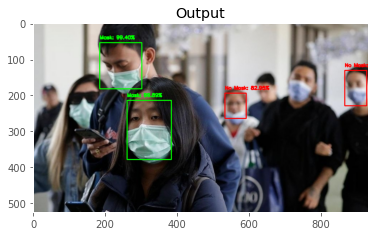

In [ ]:
# 用for迴圈進行偵測
for i in range(0, detections.shape[2]):
	# 提取概率值做偵測
	confidence = detections[0, 0, i, 2]

	# 過濾掉弱偵測
	if confidence > args["confidence"]:
		# 計算對象邊界框的 (x, y) 坐標
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# 確保邊界框在框架的尺寸範圍內
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# 提取人臉ROI(投資報酬率)值，將其從 BGR 轉換為 RGB 排序，將其調整為 224x224，並對其進行預處理
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# 將臉部通過模型以確定臉部是否有口罩
		(mask, withoutMask) = model.predict(face)[0]

		# 確定將用於繪製邊界框和文字的標籤類別和顏色
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# 在標籤中包含概率(%)
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# 在輸出的每一幀上顯示標籤和邊界框矩形
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
plt_imshow("Output", image)